# Mass Extraction Issue

First the reading of the two point correlators

In [1]:
#Library Import
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import os
import sys
sys.path.insert(1, '../')
from building_blocks_reader import bulding_block
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#folders where the dataset is
p3fold = os.environ['mount_point_path'] + "48c48/binned_1012_hmz370_BMW/3PointCorrelation/T6/"
p2fold = os.environ['mount_point_path'] + "48c48/binned_1012_hmz370_BMW/2PointCorrelation/"

#instance of the building block class
bb = bulding_block(p3fold,p2fold, maxConf=100, verbose=True)


Initializing the building block class instance...


Looping over the configurations to read the building blocks from the h5 files...



100%|██████████| 100/100 [03:23<00:00,  2.03s/it]



Looping over the configurations to read the 2-point correlators from the h5 files...



100%|██████████| 100/100 [00:13<00:00,  7.57it/s]


In [3]:
#The two point correlators are then given by
p2corr = bb.p2_corr.real
#with shape (nconf,latT)
np.shape(p2corr)

#the time extent of the lattice is
latT = np.shape(p2corr)[1]

(100, 48)

Now an implementation of the effective mass formula

$m_{eff}(t + \frac{1}{2}) = \log{\frac{C_{2p}(t)}{C_{2p}(t+1)}}$

In [110]:
#first we take the average over the gauge configurations
p2corr_gavg = np.mean(p2corr, axis=0)

#we instantiate an empty array (filled with zeros) for the mass
meff = np.zeros(shape=(latT-1,))

#we iterate over the times and compute meff according to the above formula
for t in range(latT-1):
    ratio = p2corr_gavg[t] / p2corr_gavg[t+1]
    if ratio > 1.0:
        meff[t] = np.log(ratio)
    #ratio should be bigger than 1 for the mass to positve, so for values <= 1.0 we leave meff=0

A plot of the effective mass

<Figure size 1200x800 with 0 Axes>

Text(0.5, 0, 't')

Text(0, 0.5, '$m_{eff}$')

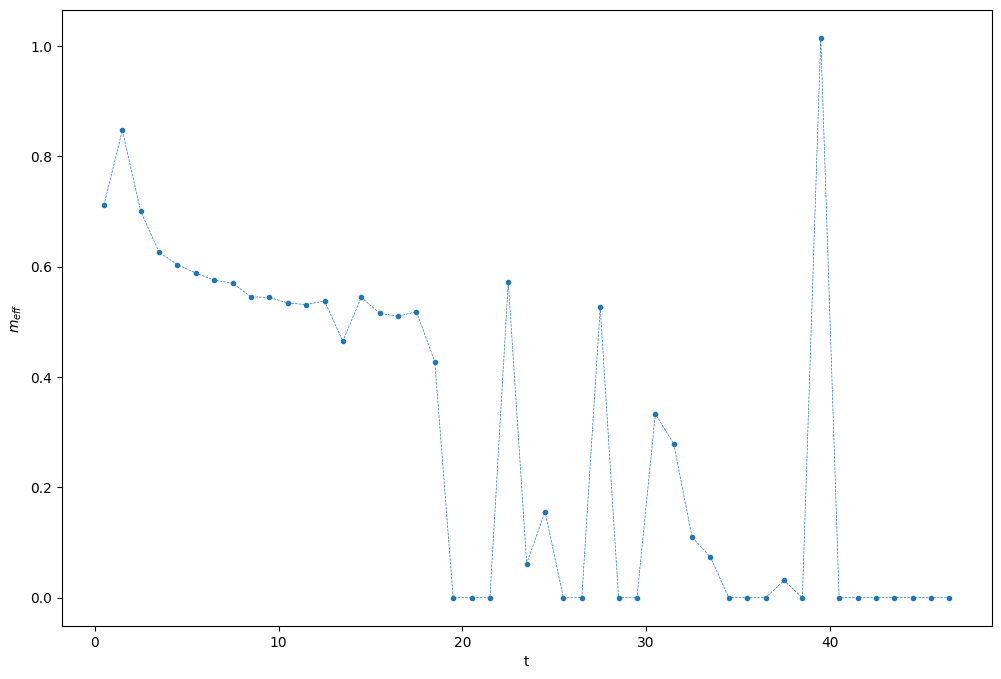

In [111]:
#on the y axis there is meff
#on the x axis we have the times
times = np.arange(latT-1) + 0.5

#we make the plot
plt.figure(figsize=(12,8))
plt.xlabel("t")
plt.ylabel(r"$m_{eff}$")
plt.plot(times, meff, marker='o', markersize=3, linestyle='dashed', linewidth=0.5)

# Using scipy fit

In [6]:
from scipy.optimize import curve_fit

def exp_fit_func(t: np.ndarray, amp: float, mass: float) -> np.ndarray:
    #we just return the exponential
    return amp * np.exp(-t * mass)

In [7]:
#then we define the first guess for the parameters of the fit
guess_amp = p2corr_gavg[0]
guess_mass = 0.5
guess = [guess_amp,guess_mass]

#we cut certain values
cut = 5

#we define the x and y arrays used for the fit (which are respectively times and p2corr_gavg)
times = np.arange(np.shape(p2corr_gavg)[0])[cut:-cut]
fit_data = p2corr_gavg[cut:-cut]

#we perform the fit
popt,pcov = curve_fit(exp_fit_func, times, fit_data, p0=guess)#,maxfev = 1300) #popt,pcov being mean and covariance matrix of the parameters extracted from the fit
perr = np.sqrt(np.diag(pcov)) #perr being the std of the parameters extracted from the fit

#we read the mass (that's the only thing we're interested about, the amplitude we discard)
fit_mass = popt[1]
fit_mass_std = perr[1]

fit_mass
fit_mass_std

np.float64(0.5773625736806565)

np.float64(0.0018767622600099239)

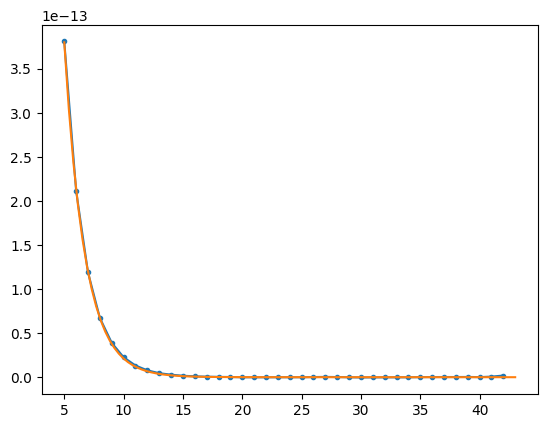

In [8]:
#plot
plt.plot(times,fit_data, marker='o', markersize=3)
lin_times = np.linspace(cut,np.shape(p2corr_gavg)[0]-cut,100)
plt.plot(lin_times,exp_fit_func(lin_times,*popt))

In [9]:
p2corr_gavg_std = np.std(p2corr, axis=0)[cut:-cut]

np.sum( (fit_data - exp_fit_func(times,*popt))**2 / p2corr_gavg_std**2 )

np.float64(0.9528206873764831)

In [10]:
a = 0.1163

fit_mass/a * 197.327

np.float64(979.6150006593542)

# Further development

In [14]:
#for kk in range(10,0,-1):
    #kk
    #10-kk
    #""
#
#for ij in range(0,1,1):
#    ij

lll = [i for i in  range(10)]

lll[2:2+5]

[2, 3, 4, 5, 6]

In [17]:
from moments_toolkit import jackknife, effective_mass

In [117]:
#function used to extract the effective mass for the two-point correlators
def new_effective_mass(corr_2p: np.ndarray, conf_axis:int=0) -> np.ndarray:
    """
    Input:
        - corr_2p: two point correlators, with shape (nconf, Tlat) (with Tlat being the time extent of the lattice)
        - conf_axis: the axis with the configurations

    Output:
        - m_eff(t): the effective mass, with shape (Tlat,) (the configuration axis gets removed) (the shape is Tlat and not Tlat-1, so that the jackknife function can be used)
    """

    #we first take the gauge average of the two point correlator
    corr_gavg = np.mean(corr_2p, axis=conf_axis)

    #we get the lattice time T
    Tlat = np.shape(corr_gavg)[0]

    #we instantiate the eff mass array with first dimension of size Tlat (even tough the effective mass should have Tlat-1 time values --> the last will be a 0 of padding)
    meff = np.zeros((Tlat))

    #we compute the effective mass (the loop as it should goes up to Tlat-1, so that the last entry of meff is a 0 of padding)
    for t in range(Tlat-1): 
        
        #to compute the mass we need the ratio of the 2-points correlator
        ratio_2p = corr_gavg[t]/corr_gavg[t+1]

        #then we just need to take the log, but for that the ratio has to be bigger than 1 (??)   (if that does not happen then the mass is set to 0 -> as done in the initialization above)
        if ratio_2p > 1.0:
            meff[t] = np.log( ratio_2p )
        #meff[t] = ratio2p_to_mass(ratio_2p,t,48)



    #we send back the effective mass
    return meff

In [149]:
#function used to compute the reduced chi2 of a 1D array using the covariance matrix
def redchi2_cov(in_array: np.ndarray, fit_array: np.ndarray, covmat: np.ndarray, only_sig:bool=True) -> float:
    """
    Input:
        - in_array: a 1D array, with len T
        - fit_array: a 1D array, also with len T, representing the function we want the in_arrya fitted to
        - covmat: a 2D array with shape (T,T), representing the covariance matrix of in_array
        - only_sig: bool, if True discards the whole covmat and looks just at its diagonal

    Output:
        - chi2: the reduced chi2 of the fit
    """

    #then we compute the differences between the fit and input array
    deltas = in_array - fit_array

    #then we compute the len of the plateaux
    len_plat = np.shape(in_array)[0]

    #TO DO: fix the issue with the covmat
    if only_sig==False:
        #first we invert the covariance array
        cov_inv = np.linalg.inv(covmat)
        #then we compute the reduced chi2 according to its formula and we return it
        return np.einsum( 'j,j->' , deltas, np.einsum('jk,k->j',cov_inv,deltas) ) / len_plat
    else:
        sig = np.sqrt(np.diag(covmat))
        return np.sum( (deltas/sig)**2 ) / len_plat

In [150]:
#function that given a 1D array returns the cut values identifying its plateaux
def plateau_search(in_array: np.ndarray, covmat: np.ndarray, only_sig=False, chi2_treshold:float=1.0) -> tuple[int,int]:
    """
    Input:
        - in_array: the 1D array we want to search the plateaux of
        - covmat: a 2D array, representing the covariance matrix of in_array
        - chi2_treshold: the treshold for the plateaux determination
    
    Output:
        - let_cut: the number of data point to be discarded from the left (beginning of the array) to arrive at the plateaux
        - right_cut: the number of data point to be discarded from the right (end of the array) to arrive at the plateaux
    """

    #first we compute the len of the array
    len_array = np.shape(in_array)[0]

    #we loop over all the possible plateau lenghts, starting from the biggest possible one and then diminishing it up to a plataeau of len 1
    for len_plat in range(len_array,0,-1):

        #then we loop over the possible initial points of the plateau
        for start_plateau in range(0,len_array-len_plat+1,1):

                #the suggested plateau region in this case is
                plat = in_array[start_plateau:start_plateau+len_plat]

                #the value of the plateau is
                plat_value = np.mean(plat,axis=0,keepdims=True)

                #we also have to reshape the covariance matrix
                covmat_plat = covmat[start_plateau:start_plateau+len_plat, start_plateau:start_plateau+len_plat]

                #we see if the chi2 meets the condition
                if redchi2_cov(plat, plat_value, covmat_plat,only_sig=only_sig) < chi2_treshold:

                    #in that case we return the values of the starting and ending point fo the plateau
                    return start_plateau, start_plateau+len_plat

    #if by the end of the loop the chi2 condition is never met we return the points corresponding to the whole dataset
    return 0, len_array

In [152]:
#we use the jackknife to compute the effective mass (mean and std)
meff, meff_std, meff_covmat = jackknife(p2corr, effective_mass, jack_axis=0, time_axis=-1)

np.where(meff<=0)
np.where(meff_std<=0)
cut=np.where(meff_std<=0)[0][0]
cut
meff = meff[:cut]
meff_std = meff_std[:cut]
meff_covmat = meff_covmat[:cut,:cut]

np.prod(meff_std)**2
np.linalg.det(meff_covmat)

(array([19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 32, 33, 34, 35, 36, 37, 38,
        39, 40, 41, 42, 43, 44, 45, 46, 47]),)

(array([19, 25, 26, 28, 29, 34, 35, 38, 40, 41, 42, 43, 44, 45, 46, 47]),)

np.int64(19)

np.float64(2.334083030876434e-64)

np.float64(2.6169586389284905e-68)

np.float64(0.0)

<ErrorbarContainer object of 3 artists>

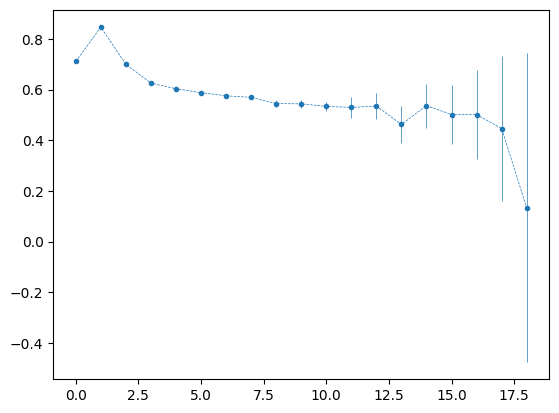

In [153]:
plt.errorbar(np.arange(0,np.shape(meff)[0]),meff,yerr=meff_std, marker='o', markersize=3, linestyle='dashed', linewidth=0.5)

In [155]:
meff
meff_std
meff_covmat
(np.abs( (meff_std-np.sqrt(np.diag(meff_covmat)) )  /meff_std ) < 10**-10 ).all()

array([0.71131904, 0.84674343, 0.70002877, 0.62599038, 0.60344751,
       0.58814105, 0.57545571, 0.5697492 , 0.54489717, 0.54387605,
       0.53370447, 0.52988708, 0.53494999, 0.46250515, 0.53677536,
       0.50168032, 0.50147956, 0.44641424, 0.13328626])

array([0.00316775, 0.00278261, 0.00315346, 0.00327906, 0.00375113,
       0.0047535 , 0.00676445, 0.00816862, 0.01236374, 0.01501986,
       0.01856958, 0.04264497, 0.05140567, 0.0730303 , 0.0867251 ,
       0.11562146, 0.17578583, 0.28601709, 0.61122777])

array([[ 1.00346225e-05,  2.51287876e-06, -3.29329445e-06,
        -1.55650354e-06, -5.12151028e-07, -1.06831587e-06,
         3.03131568e-06, -1.42533577e-06,  3.05425115e-06,
         3.46779276e-06,  1.50327756e-06,  8.89441236e-06,
         1.43550474e-05,  9.83904000e-06,  1.64416704e-05,
         3.77731865e-05,  1.14488469e-05,  1.24914553e-04,
         8.00220704e-05],
       [ 2.51287876e-06,  7.74293619e-06,  1.12395061e-06,
        -2.05711102e-06,  5.82667707e-07,  3.37908685e-07,
        -1.14319294e-06, -2.96755302e-06,  3.10638826e-06,
         3.76150052e-06,  1.73718939e-06,  1.77637305e-05,
         9.52681419e-06, -1.70751412e-06,  1.74965966e-05,
         3.96320933e-05, -4.43739623e-06,  2.21985674e-05,
        -1.38228298e-04],
       [-3.29329445e-06,  1.12395061e-06,  9.94429194e-06,
         1.17451366e-06, -1.60161266e-06, -4.70749454e-07,
        -1.46094401e-06, -5.28094519e-06, -1.63725262e-08,
        -5.12012119e-06, -2.12595125e-06,  2.05535452e-05,
    

np.True_

In [156]:
meff_std

array([0.00316775, 0.00278261, 0.00315346, 0.00327906, 0.00375113,
       0.0047535 , 0.00676445, 0.00816862, 0.01236374, 0.01501986,
       0.01856958, 0.04264497, 0.05140567, 0.0730303 , 0.0867251 ,
       0.11562146, 0.17578583, 0.28601709, 0.61122777])

In [158]:
#np.linalg.det(meff_covmat)
#for i in range(latT-5):
#    np.linalg.det(meff_covmat[:-i,:-i])

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

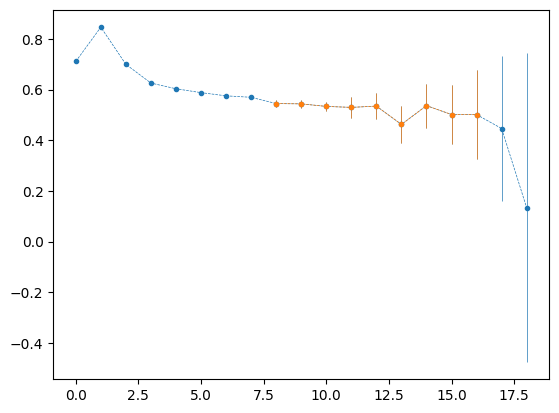

In [159]:
pstar,pend = plateau_search(meff,meff_covmat)

plt.errorbar(np.arange(0,np.shape(meff)[0]),meff,yerr=meff_std, marker='o', markersize=3, linestyle='dashed', linewidth=0.5)


plt.errorbar(np.arange(pstar,pend),meff[pstar:pend],yerr=meff_std[pstar:pend], marker='o', markersize=3, linestyle='dashed', linewidth=0.5)

meff_mean = np.mean(meff[pstar:pend])

In [160]:
np.prod(meff_std[pstar:pend])
np.linalg.det(meff_covmat[pstar:pend,pstar:pend])

np.float64(9.731210764081928e-13)

np.float64(2.4283246544878916e-26)

In [162]:
meff_plat = np.mean(meff[pstar:pend])

meff_plat_std = np.sqrt(  np.mean(meff_std[pstar:pend]**2) )

meff_plat
meff_plat_std

np.float64(0.5210839069032622)

np.float64(0.08320528262642324)

In [163]:
a = 0.1163

meff_plat/a * 197.327
meff_plat_std/a * 197.327

np.float64(884.1266044496992)

np.float64(141.1749682272074)